In [339]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import re
import seaborn as sns

from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Setup

In [327]:
df = pd.read_csv("fake_job_postings.csv",index_col='job_id')

Because we've identified the False Negative to be the errors with the highest cost and because we'd rather use a ROC_AUC score as well as the ROC curve (which has the benefit to help us fine tune the most efficient model), we've decided to swap the values in the 'fraudulent' column. This means the model will now predict if a job post is legitimate and it will allow us to minimise the False positive (when an offer is flagged as legit by the model but actually is a of fraudulent nature):

In [328]:
df['fraudulent'].replace([0,1], [1,0], inplace=True)

## Addressing the missing information

We have decided to address the missing information in the different columns by replacing the lack of information by the following values:
01. title:               No missing data
02. location:            0
03. department:          NA
04. salary_range:        0
05. company_profile:     NoText
06. description:         NoText
07. requirements:        NoText
08. benefits:            NoText
09. telecommuting:       No missing data
10. has_company_logo:    No missing data
11. has_questions:       No missing data
12. employment_type:     0
13. required_experience: 0
14. required_education:  0
15. industry:            NA
16. function:            NA
17. fraudulent:          No missing data

In [329]:
for column in ['location','salary_range','employment_type','required_experience','required_education']:
    df[column].fillna('0',inplace=True)

In [330]:
for column in ['department','industry','function']:
    df[column].fillna('NA', inplace=True)

In [331]:
for column in df.columns[4:8]:
    df[column].fillna('NoText', inplace=True)

 Some job offers have contact details or external url. Could this be linked to fraudulent activity? Could this improve our model's performance?

In [332]:
# turn into a function: use dict (columnName:textToSearch, list(dictinput.keys())[0]:list(dictinput.values())[0])
df = df.assign(hasEMAIL=0, hasPHONE=0, hasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['hasURL'][i] = 1
        elif df[column][i].find('#PHONE_')!=-1:
            df['hasPHONE'][i] = 1
        elif df[column][i].find('#EMAIL_')!=-1:
            df['hasEMAIL'][i] = 1

<ipython-input-332-aa442dc4e235>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hasURL'][i] = 1
<ipython-input-332-aa442dc4e235>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hasPHONE'][i] = 1
<ipython-input-332-aa442dc4e235>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hasEMAIL'][i] = 1


Let's see if any clear pattern can already be identified:

In [333]:
[df[column].value_counts() for column in df.columns]

[English Teacher Abroad                                311
 Customer Service Associate                            146
 Graduates: English Teacher Abroad (Conversational)    144
 English Teacher Abroad                                 95
 Software Engineer                                      86
                                                      ... 
 Reception/Administrative Assistant                      1
 Sharepoint Admin                                        1
 Tech Specialist - Microsoft Infrastructure              1
 Control Engineer                                        1
  Data Entry Representative                              1
 Name: title, Length: 11231, dtype: int64,
 GB, LND, London          718
 US, NY, New York         658
 US, CA, San Francisco    472
 GR, I, Athens            464
 0                        346
                         ... 
 US, NY, Chattanooga        1
 IN, MH, Dhule              1
 US, RI, Middletown         1
 US, SC, Easley             1
 GB, , N

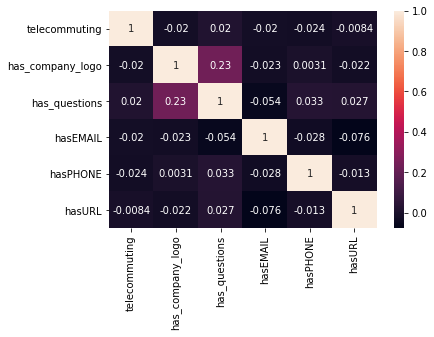

In [334]:
sns.heatmap(df.drop(columns=['fraudulent']).corr(), annot=True)

No multicollinearity issues with those binary variables

In [335]:
# inserts spaces before capitals
# re.sub(r'([A-Z][a-z])', r' \1', df['description'][1])
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        df[column][i] = re.sub(r'([A-Z][a-z])', r' \1', df[column][i])
        df[column][i] = unicodedata.normalize('NFKD',df[column][i])

<ipython-input-335-52abfc194e36>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = re.sub(r'([A-Z][a-z])', r' \1', df[column][i])
<ipython-input-335-52abfc194e36>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = unicodedata.normalize('NFKD',df[column][i])


In [336]:
[text for text in df['description']]

[' Food52, a fast-growing,  James  Beard  Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its  New  York  City headquarters. Reproducing and/or repackaging existing  Food52 content for a number of partner sites, such as  Huffington  Post,  Yahoo,  Buzzfeed, and more in their various content management systems Researching blogs and websites for the  Provisions by  Food52  Affiliate  Program Assisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiries Supporting with PR &amp;  Events when needed Helping with office administrative work, such as filing, mailing, and preparing for meetings Working with developers to document bugs and suggest improvements to the site Supporting the marketing and executive staff',
 " Organised -  Focused -  Vibrant -  Awesome! Do you have a passi

In [2]:
# split dataset in legit vs fraudulent job posts
dflegit = df[df['fraudulent']==0]
dffraud = df[df['fraudulent']==1]

/home/antoine/.local/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [3]:
# Creates a balanced dataset - UNDERSAMPLING
lil_dflegit = dflegit.sample(n=len(dffraud), random_state=666)
lil_df = pd.concat([lil_dflegit, dffraud])
lil_df['fraudulent'].value_counts()

1    866
0    866
Name: fraudulent, dtype: int64

In [337]:
labels = df['fraudulent']
features = df.drop(columns=['fraudulent'])

# Train Test Split

In [6]:
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                    labels,
                                                    random_state=666)

features_train, features_validate, labels_train, labels_validate = train_test_split(features_train,
                                                           labels_train,
                                                           random_state=666
                                                           )

# Initialising K-Folds
# kfold = KFold(n_splits=5,
#               random_state=666,
#               shuffle=True
#              )

# TF-IDF computation

In [7]:
tokenizer = RegexpTokenizer(r'\w+')
vect = TfidfVectorizer(input='content', stop_words='english',tokenizer=tokenizer)

In [8]:
#fit_transform
features_train_vectorized = vect.fit_transform([document for document in features_train['requirements']])
#transform
features_validate_vectorized = vect.transform([document for document in features_validate['requirements']])
features_test_vectorized = vect.transform([document for document in features_test['requirements']])

## Shape check

In [9]:
print('requirements in train set:', len([document for document in features_train['requirements']]))
print('shape of densified train [[tfidf]]:', features_train_vectorized.todense().shape)

requirements in train set: 974
shape of densified train [[tfidf]]: (974, 7741)


In [10]:
print('requirements in validation set:', len([document for document in features_validate['requirements']]))
print('shape of densified validation [[tfidf]]:', features_validate_vectorized.todense().shape)

requirements in validation set: 325
shape of densified validation [[tfidf]]: (325, 7741)


In [11]:
print('requirements in test set:', len([document for document in features_test['requirements']]))
print('shape of densified test [[tfidf]]:', features_test_vectorized.todense().shape)

requirements in test set: 433
shape of densified test [[tfidf]]: (433, 7741)


# Addressing the class imbalance

In [340]:
# SMOTE doesn't work on text, it needs to be changed to TF-IDF
sm = SMOTE(random_state=666, n_jobs=4)

In [341]:
X, y = sm.fit_resample(labels, features)

TypeError: '<' not supported between instances of 'int' and 'str'

In [ ]:
# This code should show a graphical representation of the SMOTE results

counter = Counter(labels)
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
pltt.show()

# Gaussian Naive Bayes

In [12]:
gnb = GaussianNB()

In [13]:
gnb.fit(features_train_vectorized.todense(), labels_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [14]:
labels_train_pred = gnb.predict(features_train_vectorized.todense())
labels_validate_pred = gnb.predict(features_validate_vectorized.todense())

In [15]:
print('Accuracy (on train set):', (labels_train_pred==labels_train).sum()/labels_train.count())
print('Accuracy (on validation set):', (labels_validate_pred==labels_validate).sum()/labels_validate.count())

Accuracy (on train set): 0.9209445585215605
Accuracy (on validation set): 0.7876923076923077


Massive overfit!

# Multinomial Naive Bayes

In [16]:
mnb = MultinomialNB()

In [17]:
mnb.fit(features_train_vectorized.todense(), labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
labels_train_pred = mnb.predict(features_train_vectorized.todense())
labels_validate_pred = mnb.predict(features_validate_vectorized.todense())

In [19]:
print('Accuracy (on train set):', (labels_train_pred==labels_train).sum()/labels_train.count())
print('Accuracy (on validation set):', (labels_validate_pred==labels_validate).sum()/labels_validate.count())

Accuracy (on train set): 0.893223819301848
Accuracy (on validation set): 0.7846153846153846


Massive overfit!

# Random Forest

In [20]:
rfc = RandomForestClassifier(n_estimators=100)

In [21]:
rfc.fit(features_train_vectorized.todense(), labels_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
labels_train_pred = rfc.predict(features_train_vectorized.todense())
labels_validate_pred = rfc.predict(features_validate_vectorized.todense())

In [23]:
print('Accuracy (on train set):', (labels_train_pred==labels_train).sum()/labels_train.count())
print('Accuracy (on validation set):', (labels_validate_pred==labels_validate).sum()/labels_validate.count())

Accuracy (on train set): 0.9281314168377823
Accuracy (on validation set): 0.7876923076923077


Massive overfit!

## EDA following TF-IDF

In [24]:
[text for text in dffraud[dffraud['requirements'].str.find('URL')!=-1]['requirements']]

['Position Requirements: Experience supporting and developing on a version of CA’s service management software including SDM, CMDB, ITAM, ITPAM, and CAPA – version 12 a plusOO design conceptsJava, C# , VB.net, &amp;.Net Framework skills requiredMicrosoft Reporting ServicesBusiness Objects XIRDBMS – SQL Server and Oracle preferredXML – Web services and SOAP#URL_86fd830a95a64e2b30ceed829e63fd384c289e4f01e3c93608b42a84f6e662dd# a plusKnowledge of ITIL and/or Six Sigma and SDLCStrong interpersonal skillsHighly motivated and self-directedKnowledge of data securityStrong written and oral communication skillsProven analytical and problem-solving abilitiesExperience migrating a problem/change management system from one version to another and/or to a new product. Not required, but a plus.Knowledge of other problem and change management systems is a plus (ie, HP, IBM,\xa0 Symantec, etc..)\xa0\xa0',
 'Job RequirementsTechnical Requirements:Working knowledge of: MapInfo GIS, ArcGIS, SMT Kingdom Su